In [12]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

In [18]:
class Net(nn.Module):
    def __init__(self, embedding_size, vocab_size):
        super().__init__()
        # self.nn = nn.Sequential(
        #     nn.Linear(vocab_size, embedding_size),
        #     nn.Linear(embedding_size, vocab_size)
        # )

        self.linear_1 = nn.Linear(vocab_size, embedding_size)
        self.linear_2 = nn.Linear(embedding_size, vocab_size)

    def forward(self, x):
        # return self.nn(x)
        x_1 = self.linear_1(x)
        x_2 = self.linear_2(x_1)
        return x_2, x_1


# make fake data
sentences = [
    "apple banana fruit",
    "banana orange fruit",
    "orange banana fruit",
    "dog cat animal",
    "cat monkey animal",
    "monkey dog animal"
]
# make vocab set
cat_sentences = " ".join(sentences).split(' ')
word_all = " ".join(sentences).split(' ')
word_list = list(set(word_all))
vocab_size = len(word_list)
print(f'word list: {word_list}, size: {vocab_size}')
# stoi
stoi = {
    v: k for k, v in enumerate(word_list)
}
print(f'stoi: {stoi}')


# make skip gram
skip_gram = [] # each element is pair include [target, context]
for i in range(1, len(cat_sentences) - 1):
    # print(f'i: {i}')
    target_word = cat_sentences[i]
    # convert to index
    target_index = stoi[target_word]

    context_word = []
    d = 1
    for j in range(i+1, i+d+1):
        # print(f'j: {j}')
        context_word.append(cat_sentences[j])

    for j in range(i-d, i):
        # print(f'j: {j}')
        context_word.append(cat_sentences[j])

    context_index = [stoi[j] for j in context_word]

    for word_index in context_index:
        skip_gram.append([target_index, word_index])

print(f'skip gram: {skip_gram}')


def collate_batch(batch):
    inputs = [] # target
    label = [] # context
    for i in range(len(batch)):
        inputs.append(
            np.eye(vocab_size)[batch[i][0]]
        )
        label.append(
            batch[i][1]
        )

    # convert to tensor
    inputs = torch.tensor(inputs, dtype=torch.float32)
    label = torch.tensor(label, dtype=torch.long)
    # inputs = torch.from_numpy(inputs)
    # label = torch.from_numpy(label)

    return inputs, label

# dataloader
loader = torch.utils.data.DataLoader(
    dataset=skip_gram,
    batch_size=8,
    shuffle=True,
    collate_fn=collate_batch
)

# test data
for inputs, label in loader:
    print(f'inputs: {inputs}, label: {label}')
    break

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
model = Net(embedding_size=2, vocab_size=vocab_size).to(device) # 2 for visualize
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = torch.nn.CrossEntropyLoss()


word list: ['monkey', 'dog', 'orange', 'fruit', 'cat', 'apple', 'animal', 'banana'], size: 8
stoi: {'monkey': 0, 'dog': 1, 'orange': 2, 'fruit': 3, 'cat': 4, 'apple': 5, 'animal': 6, 'banana': 7}
skip gram: [[7, 3], [7, 5], [3, 7], [3, 7], [7, 2], [7, 3], [2, 3], [2, 7], [3, 2], [3, 2], [2, 7], [2, 3], [7, 3], [7, 2], [3, 1], [3, 7], [1, 4], [1, 3], [4, 6], [4, 1], [6, 4], [6, 4], [4, 0], [4, 6], [0, 6], [0, 4], [6, 0], [6, 0], [0, 1], [0, 6], [1, 6], [1, 0]]
inputs: tensor([[0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.]]), label: tensor([2, 3, 7, 1, 6, 6, 6, 7])


In [14]:
history_loss = []
epochs = 1000
for epoch in range(epochs):
    # pbar = tqdm(enumerate(loader))
    pbar = enumerate(loader)
    loss_per_epoch = []
    start_time_epoch = time.time()
    for batch_idx, (inputs, label) in pbar:
        inputs = inputs.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        out, _ = model(inputs)
        # loss = torch.nn.functional.cross_entropy(out, label)
        loss = criterion(out, label)
        loss_per_epoch.append(loss.item())
        loss.backward()
        optimizer.step()

    loss_epoch = np.mean(loss_per_epoch)
    if epoch == 0 or loss_epoch < history_loss[-1]:
        history_loss.append(loss_epoch)
        torch.save(model.state_dict(), 'net.pt')

    if epoch % 200 == 0:
        print(f'loss: {loss_epoch}, time_train: {time.time() - start_time_epoch}')

loss: 2.1493030190467834, time_train: 0.006707429885864258
loss: 1.115750104188919, time_train: 0.004768848419189453
loss: 1.0726203322410583, time_train: 0.004949092864990234
loss: 1.0523369908332825, time_train: 0.006592273712158203
loss: 1.0442535430192947, time_train: 0.004913806915283203


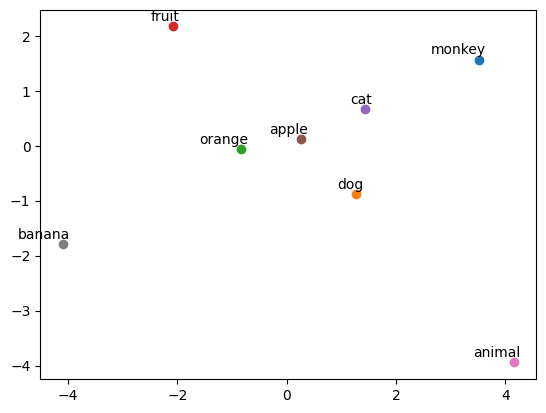

In [15]:
# visualize in embedding_space
# with torch.no_grad():
#     for w_idx, w in enumerate(word_list):
#         w_idx_vec = np.eye(vocab_size)[w_idx]
#         w_idx_vec = torch.tensor(w_idx_vec, dtype=torch.float32)
#         _, x_v = model(w_idx_vec)
#         print(f'x_v: {x_v}')
#         x, y = x_v[0].item(), x_v[1].item()
#         # print(f'x: {x}, y: {y}')
#         plt.scatter(x, y)

model = Net(embedding_size=2, vocab_size=8)
model.load_state_dict(torch.load('net.pt', weights_only=True))
model.eval()

X = []
Y = []
for w_idx, w in enumerate(word_list):
    w_idx_vec = np.eye(vocab_size)[w_idx]
    w_idx_vec = torch.tensor(w_idx_vec, dtype=torch.float32)
    _, x_v = model(w_idx_vec)
    # print(f'x_v: {x_v}')
    x, y = x_v[0].item(), x_v[1].item()
    # print(f'x: {x}, y: {y}')
    X.append(x)
    Y.append(y)
    plt.scatter(x, y)
    plt.annotate(w, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')

# plt.scatter(X, Y)